In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFE
from collections import Counter

Read and Encode test data

In [330]:
df = pd.read_csv("test_data cs 1.csv")
pd.set_option('future.no_silent_downcasting', True)
df = df.sample(n=1000, replace=False, random_state=42)

label_encoder = LabelEncoder()
df['text'] = label_encoder.fit_transform(df['text'])
df['screen_name'] = label_encoder.fit_transform(df['screen_name'])

df["verified"] = df["verified"].replace({"f": 0, "t": 1})


df["created_at"] = pd.to_datetime(df["created_at"], format="%a %b %d %H:%M:%S %Y")
df["hour"] = df["created_at"].dt.hour
df["weekday"] = df["created_at"].dt.weekday
df["month"] = df["created_at"].dt.month
df["year"] = df["created_at"].dt.year
df = df.drop(columns=["created_at"]) 

categorical_cols = ["user_lang", "lang", "time_zone", "location", "source"]
for col in categorical_cols:
    freq_map = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].replace(freq_map)

eyewitness_order = {"don't know": -1, "non-eyewitness": 0, "indirect-eyewitness": 1, "direct-eyewitness": 2}
df["label"] = df["label"].replace(eyewitness_order)

for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

num_cols = ["followers_count", "statuses_count", "friends_count", "favourites_count",
            "listed_count", "cred_score", "eye_truth", "compare_text", "screen_name", "text"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

Train/test split


In [331]:

X = df.drop("verified", axis=1)
y = df["verified"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)


GBC using all features of the dataset

In [332]:
gbc = GradientBoostingClassifier(random_state=42)

gbc.fit(X_train, y_train)
preds = gbc.predict(X_test)

f1_score_all = round(f1_score(y_test, preds, average='weighted'), 3)
print(f"F1 Score: {f1_score_all}")

F1 Score: 0.939


Variance Treshold Method

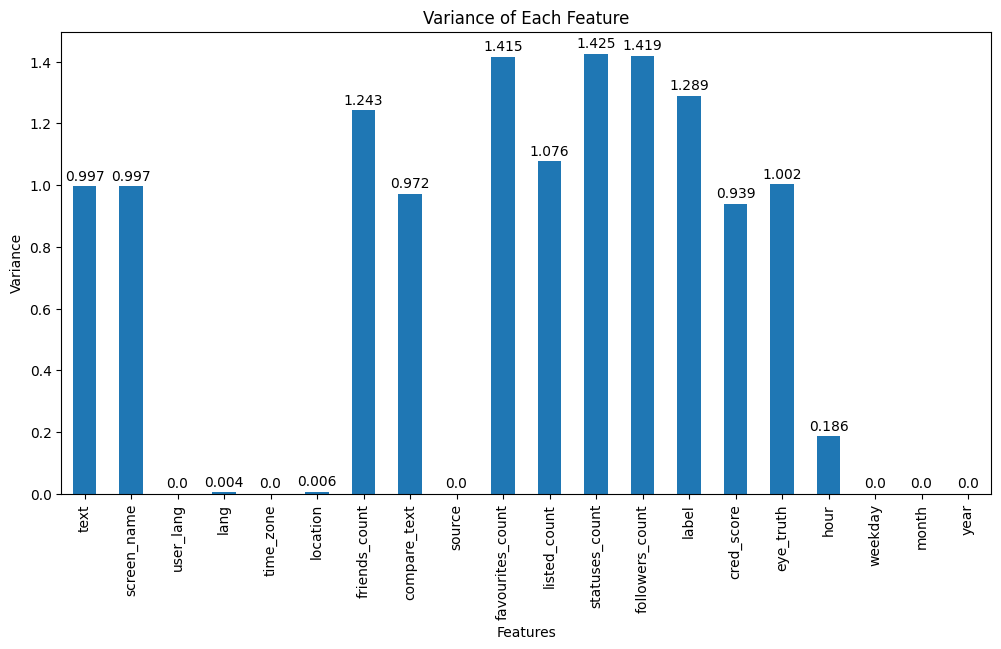

In [333]:
X_train_V, X_test_V, y_train_V, y_test_V = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
variance = X_train_V.var()
plt.figure(figsize=(12, 6))
ax = variance.plot(kind='bar')
for i, v in enumerate(variance):
    ax.text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=10)
plt.title('Variance of Each Feature')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.show()

Dropping Features with variance below 0.8

In [334]:
sel_X_train = X_train_V.drop(["user_lang", "lang", "time_zone", "location", "source", "hour", "weekday", "month", "year"], axis=1)
sel_X_test = X_test_V.drop(["user_lang", "lang", "time_zone", "location", "source", "hour", "weekday", "month", "year"], axis=1)
gbc.fit(sel_X_train, y_train_V)
var_preds = gbc.predict(sel_X_test)
f1_score_var = round(f1_score(y_test_V, var_preds, average="weighted"), 3)
print(f1_score_var)

0.942


SelectKbest feature selection (filter)

In [338]:
X_train_V1, X_test_V1, y_train_V1, y_test_V1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

f1_score_list = []
feature_counts = []
selected_features_dict = {}

for k in range(1, 21):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_V1, y_train_V1)

    selected_feature_mask = selector. get_support()
    selected_features = X_train_V1.columns[selected_feature_mask]
    selected_features_dict[k] = list(selected_features) 

    selected_X_train = selector.transform(X_train_V1)
    selected_X_test = selector.transform(X_test_V1)

    gbc.fit(selected_X_train, y_train_V1)
    kbest_preds = gbc.predict(selected_X_test)

    f1_score_kbest = round(f1_score(y_test_V1, kbest_preds, average="weighted"), 3)
    f1_score_list.append(f1_score_kbest)
    feature_counts.append(k)

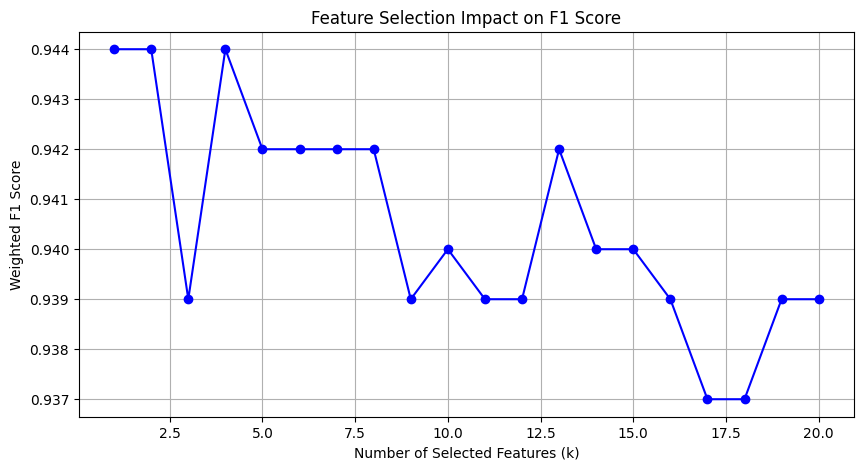

In [342]:
plt.figure(figsize=(10, 5))
plt.plot(feature_counts, f1_score_list, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Weighted F1 Score")
plt.title("Feature Selection Impact on F1 Score")
plt.grid(True)
plt.show()

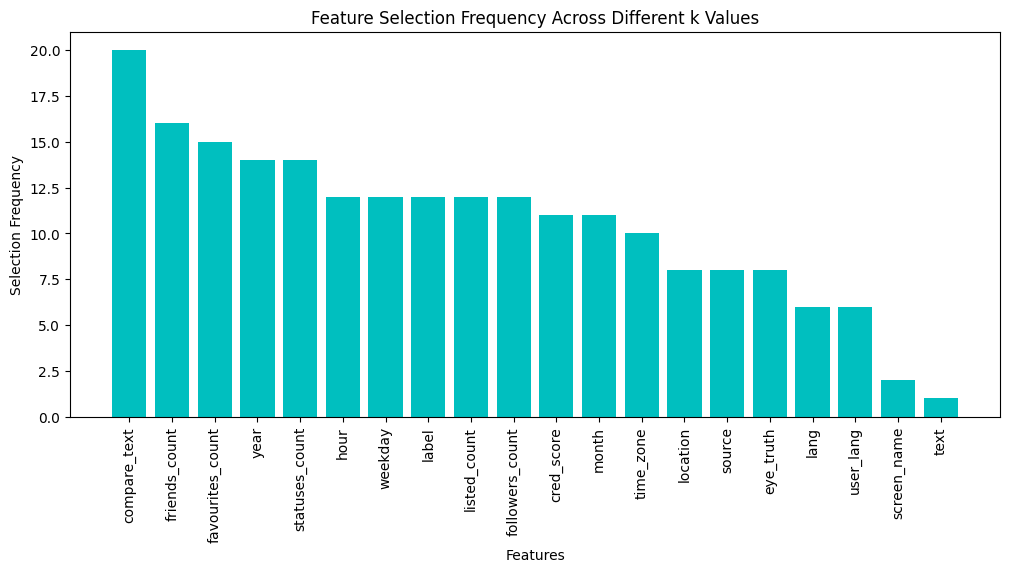

In [345]:
all_selected_features = [feature for features in selected_features_dict.values() for feature in features]
feature_counts = Counter(all_selected_features)

sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
features, counts = zip(*sorted_features)

plt.figure(figsize=(12, 5))
plt.bar(features, counts, color='c')
plt.xlabel("Features")
plt.ylabel("Selection Frequency")
plt.xticks(rotation=90) 
plt.title("Feature Selection Frequency Across Different k Values")
plt.show()

Recursive Feature Elimination (Wrapper)

In [ ]:
X_train_V2, X_test_V2, y_train_V2, y_test_V2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

ref_f1_scores = []

for k in range(1, 21):
    RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train_V2, y_train_V2)

    sel_X_train_V2 = RFE_selector.transform(X_train_V2)
    sel_X_test_V2 = RFE_selector.transform(X_test_V2)

    selected_features = np.where(RFE_selector.support_)[0]
    feature_counts.update(selected_features)
    
    gbc.fit(sel_X_train_V2, y_train_V2)
    RFE_preds = gbc.predict(sel_X_test_V2)

    f1_score_RFE = round(f1_score(y_test_V2, RFE_preds, average="weighted"), 3)
    ref_f1_scores.append(f1_score_RFE)


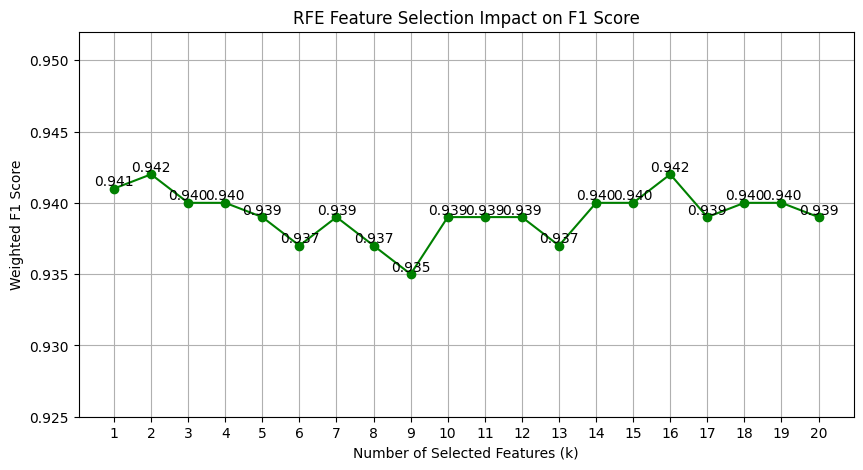

In [353]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), ref_f1_scores, marker='o', linestyle='-', color='g')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Weighted F1 Score")
plt.title("RFE Feature Selection Impact on F1 Score")
plt.xticks(range(1, 21))
plt.ylim(min(ref_f1_scores) - 0.01, max(ref_f1_scores) + 0.01)
plt.grid(True)

for i, score in enumerate(ref_f1_scores, 1):
    plt.text(i, score, f"{score:.3f}", ha='center', va='bottom', fontsize=10)

plt.show()
